# Introduction to Machine Learning HW4

----

#### 姓名：王祥任
#### 學號：0616309

----


## Import Modules

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import urllib3
import copy
import sklearn as sk
import math
import random as rnd
from sklearn import datasets
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
import tensorflow as tf

## plot_confusion_matrix function taken from sklearn sample with some modification
> Reference : HW1 Sample Code

In [7]:
def plot_confusion_matrix(y_true, y_pred, classes,        
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(20, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Data Loading & Preprocessing


In [8]:
# Import Word2Vec
from gensim.models.word2vec import Word2Vec

# Data Loading
train = pd.read_json('train.json')
test = pd.read_json('test.json')

# Prepare Data for Word2Vec
train_ingredients = [d[0] for d in train.drop(['id', 'cuisine'], axis=1).values.tolist()]
test_ingredients = [d[0] for d in test.drop(['id'], axis=1).values.tolist()]

all_ingredients = []
for d in train_ingredients:
    all_ingredients.append(d)
for d in test_ingredients:
    all_ingredients.append(d)

# Prepare 
model = Word2Vec(all_ingredients, size=300, iter=20, min_count=1, workers=12)


In [9]:
train = pd.read_json('train.json')
train_set = []
for data in train.values.tolist():
    tmp = []
    tmp.append(data[1])
    gre_vec = np.array([0 for _ in range(300)])
    for gre in data[2]:
        gre_vec = np.add(gre_vec, np.array(model.wv[gre]))
    tmp.extend(gre_vec)
    train_set.append(tmp)
train_set = pd.DataFrame(train_set)

le = sk.preprocessing.LabelEncoder()
le.fit(train_set[0])

classes = le.classes_

train_set[0] = le.transform(train_set[0])
train_set

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,9,-0.597537,-2.054060,-1.973298,-1.654513,1.471486,0.046912,-0.171017,-1.334454,-4.595249,...,0.421830,0.111980,-2.289206,0.640249,2.242085,-3.103051,-1.292019,1.781146,-0.832783,1.439122
1,16,-2.356562,-2.950097,-0.861588,-2.552600,0.239519,-0.803003,-0.210254,0.384253,-5.002999,...,-1.358933,0.396685,-1.529665,0.247728,0.252700,-1.453016,-3.529934,-0.072023,1.546057,0.391104
2,18,-0.791646,1.711813,-0.367262,-0.606845,4.359360,0.541723,-1.521228,1.065277,-4.035161,...,-2.737186,-1.402049,-0.185902,1.814889,1.698329,-2.551957,-1.693685,1.035982,3.074465,1.727919
3,14,-0.071347,-0.798529,-0.854968,-0.583865,1.316516,-0.513758,0.416940,-0.128853,-1.955895,...,-0.334878,0.149423,-0.055100,0.198894,0.445036,-0.152400,-1.399498,0.209909,-0.070439,0.275305
4,3,-0.764357,0.952431,-0.983695,0.387255,1.411429,0.946244,-1.176015,-0.749495,-2.417730,...,-1.020558,0.314235,-0.428203,1.040375,1.277182,-2.783291,-0.763744,0.764761,1.368455,1.342262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29769,11,-1.123827,3.414409,-0.870452,-0.439256,3.121025,-1.304707,-2.687168,0.147013,-4.018839,...,-2.650378,-2.510193,-1.860808,2.622245,1.796664,-1.310368,-1.528261,1.983709,2.504416,3.561609
29770,19,-0.727330,3.779868,0.629800,1.395311,2.583905,-0.353011,-0.480086,-0.226015,-1.396111,...,-2.215427,-0.984460,-0.140701,0.949969,0.687053,-0.896527,-1.555204,0.293338,2.248654,2.284032
29771,7,-0.624416,-0.839520,-1.128117,-0.936014,2.204080,0.606596,-2.373303,0.859492,-1.381911,...,0.056869,-4.211072,0.063573,2.715321,2.582786,-2.577933,-1.788097,1.816311,3.403547,3.509338
29772,16,-0.687607,-1.169735,-0.630617,-1.389061,0.048686,-0.082581,0.424669,0.088007,-1.673367,...,0.157175,0.972040,-1.347304,-0.260645,-0.090959,-1.462312,-2.396443,0.114589,-0.391129,-0.059898


## Holdout 7:3

Epoch 1/50
652/652 [==============================] - 3s 4ms/step - loss: 1.5557 - accuracy: 0.5453
Epoch 2/50
652/652 [==============================] - 2s 3ms/step - loss: 1.0769 - accuracy: 0.6660
Epoch 3/50
652/652 [==============================] - 2s 3ms/step - loss: 1.0505 - accuracy: 0.6701
Epoch 4/50
652/652 [==============================] - 2s 3ms/step - loss: 0.9961 - accuracy: 0.6823
Epoch 5/50
652/652 [==============================] - 2s 3ms/step - loss: 0.9795 - accuracy: 0.6882
Epoch 6/50
652/652 [==============================] - 2s 4ms/step - loss: 0.9671 - accuracy: 0.6968
Epoch 7/50
652/652 [==============================] - 2s 3ms/step - loss: 0.9490 - accuracy: 0.6963
Epoch 8/50
652/652 [==============================] - 2s 3ms/step - loss: 0.9131 - accuracy: 0.7104
Epoch 9/50
652/652 [==============================] - 2s 3ms/step - loss: 0.9058 - accuracy: 0.7127
Epoch 10/50
652/652 [==============================] - 2s 3ms/step - loss: 0.9167 - accuracy: 0.7082

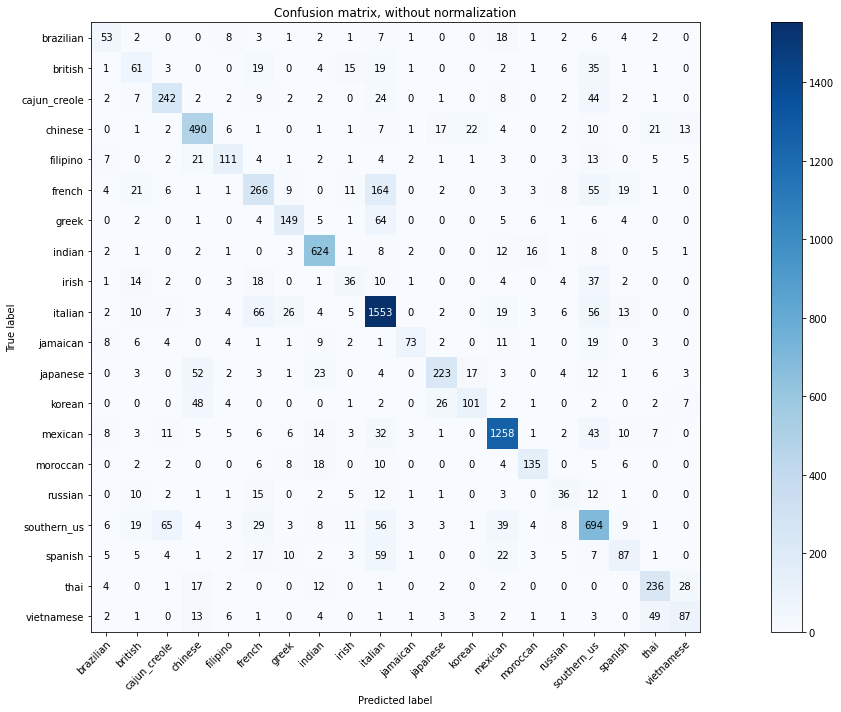

In [10]:
def hold_out(data, classes, model_type='svm', target_name=0, ratio=0.7, random_state=0):
    # Split Data
    y = data[target_name] # Target
    x = data.drop(target_name, axis=1) # Attribute
    train_x, valid_x, train_y, valid_y = train_test_split(x, y, train_size=ratio, random_state=random_state) # ratio = 7:3

    # train Model
    if model_type == 'svm':
        clf = sk.svm.SVC()
        clf.fit(train_x, train_y)
        # Predict
        pred = clf.predict(valid_x)
    elif model_type == 'ann' :
        clf = tf.keras.models.Sequential([
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(300, activation='sigmoid'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(600, activation='sigmoid'),
            tf.keras.layers.Dense(20, activation='sigmoid')
        ])

        clf.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

        clf.fit(train_x, train_y, epochs=50)
        # Predict
        pred = clf.predict(valid_x)
        pred = [np.argmax(d) for d in pred]

    # Display
    cl_labels = np.array(classes)

    print("|-----|-----|-----|-----|-----|")
    print("              %s              " % (model_type))
    print("|-----|-----|-----|-----|-----|")

    print(classification_report(valid_y, pred, target_names=cl_labels))
    plot_confusion_matrix(valid_y, pred, classes=cl_labels, cmap=plt.cm.Blues)
    plt.show()

# hold_out(train_set, classes, 'svm')
hold_out(train_set, classes, 'ann')

## Without Word2Vec

In [6]:
train = pd.read_json('train.json')

enc = {}
enc_idx = 0

train_set_zp = []
for data in train.values.tolist():
    tmp = []
    tmp.append(data[1])
    for gre in data[2]:
        if gre in enc.keys():
            tmp.append(enc[gre])
        else:
            enc_idx+=1
            enc[gre] = enc_idx
            tmp.append(enc[gre])
    train_set_zp.append(tmp)
train_set_zp = pd.DataFrame(train_set_zp)

le = sk.preprocessing.LabelEncoder()
le.fit(train_set_zp[0])

classes = le.classes_

train_set_zp[0] = le.transform(train_set_zp[0])
train_set_zp = train_set_zp.fillna(0)
train_set_zp

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,9,1,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,16,12,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,18,22,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14,9,34.0,35.0,31.0,36.0,37.0,38.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,30,39.0,40.0,11.0,41.0,42.0,26.0,43.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29769,11,26,353.0,24.0,873.0,80.0,65.0,464.0,190.0,1153.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29770,19,471,775.0,2820.0,761.0,119.0,951.0,13.0,1916.0,771.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29771,7,191,210.0,50.0,43.0,190.0,168.0,13.0,101.0,626.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29772,16,15,218.0,489.0,18.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


|-----|-----|-----|-----|-----|
              svm              
|-----|-----|-----|-----|-----|
              precision    recall  f1-score   support

   brazilian       0.00      0.00      0.00       111
     british       0.00      0.00      0.00       169
cajun_creole       0.00      0.00      0.00       350
     chinese       0.00      0.00      0.00       599
    filipino       0.00      0.00      0.00       186
      french       0.07      0.00      0.01       574
       greek       0.00      0.00      0.00       248
      indian       0.16      0.01      0.02       687
       irish       0.00      0.00      0.00       133
     italian       0.21      0.88      0.34      1779
    jamaican       0.00      0.00      0.00       145
    japanese       0.00      0.00      0.00       357
      korean       0.00      0.00      0.00       196
     mexican       0.15      0.14      0.14      1418
    moroccan       0.00      0.00      0.00       196
     russian       0.00      0.00      

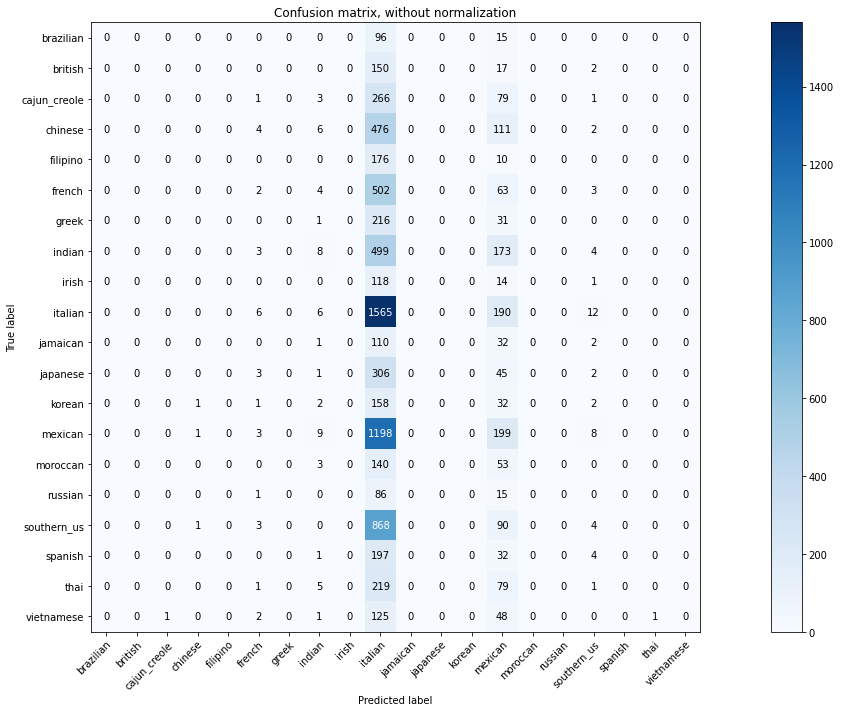

Epoch 1/50
652/652 [==============================] - 2s 3ms/step - loss: 2.6642 - accuracy: 0.1856
Epoch 2/50
652/652 [==============================] - 2s 3ms/step - loss: 2.5937 - accuracy: 0.1955
Epoch 3/50
652/652 [==============================] - 2s 3ms/step - loss: 2.5741 - accuracy: 0.2106
Epoch 4/50
652/652 [==============================] - 2s 3ms/step - loss: 2.5756 - accuracy: 0.2043
Epoch 5/50
652/652 [==============================] - 2s 3ms/step - loss: 2.5684 - accuracy: 0.2093
Epoch 6/50
652/652 [==============================] - 2s 4ms/step - loss: 2.5686 - accuracy: 0.2099
Epoch 7/50
652/652 [==============================] - 2s 4ms/step - loss: 2.5703 - accuracy: 0.2075
Epoch 8/50
652/652 [==============================] - 2s 3ms/step - loss: 2.5652 - accuracy: 0.2073
Epoch 9/50
652/652 [==============================] - 2s 3ms/step - loss: 2.5734 - accuracy: 0.2076
Epoch 10/50
652/652 [==============================] - 2s 3ms/step - loss: 2.5589 - accuracy: 0.2071

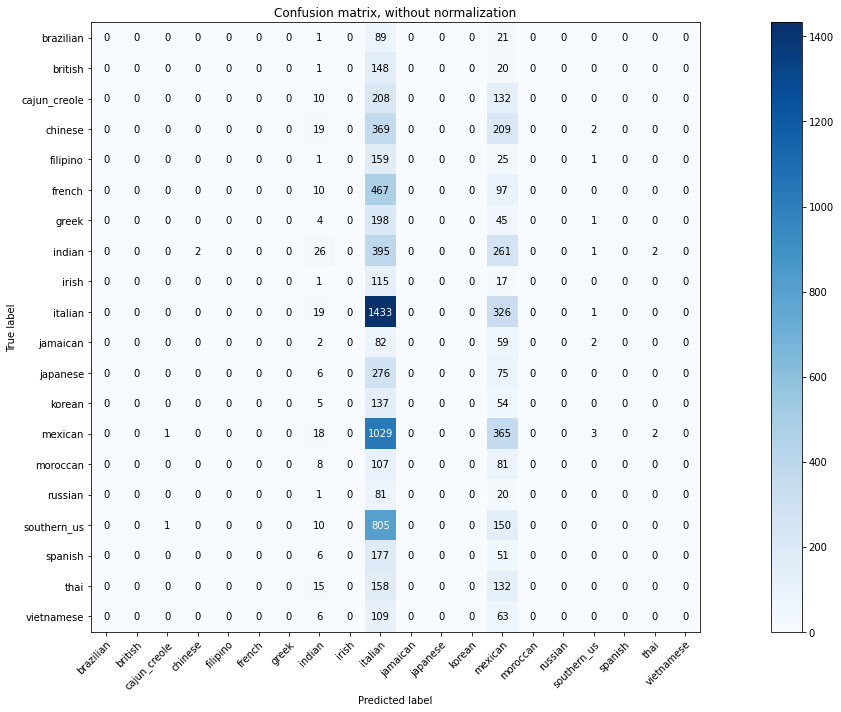

In [7]:
hold_out(train_set_zp, classes, 'svm')
hold_out(train_set_zp, classes, 'ann')

# Kaggle

In [8]:
train = pd.read_json('train.json')
train_set = []
for data in train.values.tolist():
    tmp = []
    tmp.append(data[1])
    gre_vec = np.array([0 for _ in range(300)])
    for gre in data[2]:
        gre_vec = np.add(gre_vec, np.array(model.wv[gre]))
    tmp.extend(gre_vec)
    train_set.append(tmp)
train_set = pd.DataFrame(train_set)

le = sk.preprocessing.LabelEncoder()
le.fit(train_set[0])

classes = le.classes_

train_set[0] = le.transform(train_set[0])
train_set

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,9,0.238818,0.303153,5.315320,-7.370948,-0.455378,0.116722,-4.147923,-1.422453,2.405939,...,1.212409,2.439867,3.484656,1.204689,1.420847,-2.574639,2.318046,0.343153,0.283212,-0.277235
1,16,2.737144,2.362122,4.973554,-8.739176,3.266661,-5.407409,-6.647935,-8.041275,-2.988771,...,-0.194249,5.209339,6.493497,2.227396,4.719215,-5.270191,1.027259,-0.067161,1.422741,-6.231057
2,18,-3.589849,-0.953200,2.531529,-0.402473,-0.319624,-1.627725,2.398398,3.766672,-1.998256,...,-7.259460,-4.377182,1.601082,1.129105,4.073806,-4.110794,2.724557,2.548593,-2.370385,-3.446652
3,14,-0.210919,0.114153,0.148416,-2.531337,-1.081856,-1.760056,-1.349604,-0.376136,-2.294764,...,-1.162223,-0.629345,0.691926,0.106017,-0.514624,0.841586,0.509824,-0.245116,0.284444,-0.744564
4,3,-2.863861,-1.695324,0.914941,-3.206416,-0.046017,2.657843,1.689187,1.643952,-1.192771,...,-1.440732,-1.368392,0.455568,1.525288,0.890215,-1.533932,-0.260161,1.591438,-0.564448,-1.925785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29769,11,-2.825081,1.537133,5.770146,2.697945,-3.570051,1.171974,4.642892,6.062678,-1.065510,...,-4.318299,1.826868,-0.297474,3.991747,6.408511,-2.835699,2.997864,1.318055,-3.757722,-6.067781
29770,19,-3.379533,1.262817,1.942501,2.856825,1.005241,-3.186072,2.572827,-0.232596,-1.288608,...,-3.609659,-4.031019,-1.786661,0.730009,2.450670,-1.733233,2.430392,2.360123,-0.704239,-3.153568
29771,7,-1.267926,0.163935,-3.553619,5.711814,-2.459046,1.564119,0.088189,7.957433,-0.242071,...,-0.891979,1.656557,2.969361,-0.787360,6.383819,-2.767314,-0.436528,4.306038,3.822353,-3.762677
29772,16,2.805058,1.412490,2.393378,-6.385710,2.254468,-3.492600,-4.041852,-5.857834,-1.355088,...,-1.340367,2.973245,3.546304,1.120644,2.036013,0.465217,0.165790,0.049521,2.429410,-1.392316


In [9]:
test = pd.read_json('test.json')
test_set = []
for data in test.values.tolist():
    tmp = []
    gre_vec = np.array([0 for _ in range(300)])
    for gre in data[1]:
        gre_vec = np.add(gre_vec, np.array(model.wv[gre]))
    tmp.extend(gre_vec)
    test_set.append(tmp)
test_set = pd.DataFrame(test_set)
test_set

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,1.577938,2.599471,0.274966,-2.416629,1.785182,-2.586135,-4.912093,-3.153076,0.619228,-1.032597,...,0.009104,0.787277,-1.271818,0.181578,-0.142467,-2.664051,0.096238,-0.626443,-0.255826,1.000971
1,-1.380193,-4.104128,2.292702,5.932305,2.727462,0.165515,-3.103973,-2.827201,1.566243,2.182977,...,-2.171985,2.537701,1.649020,1.848438,3.553867,-7.571367,-0.396318,3.879484,-0.727853,1.443387
2,-0.965286,-2.253518,-1.996960,2.283140,0.724701,0.054082,-1.166664,0.461097,-1.199142,1.085468,...,-3.373932,-2.877352,-1.665824,-0.974265,3.845791,-0.270256,-0.599373,2.045484,1.761509,0.476016
3,-6.823710,-0.438911,-10.532974,-1.777314,3.177015,-0.879832,-4.879844,0.827210,-7.764370,-2.404388,...,0.237255,-7.496697,-5.502536,-4.031058,1.435439,-2.226567,-0.661289,1.511405,0.821143,-2.292363
4,-0.313745,0.575374,-1.850768,0.952733,4.983714,-3.846129,-3.428147,-5.321954,-4.752195,-1.557896,...,0.418305,-9.286792,-5.220110,-5.409768,1.543346,-1.114773,0.182226,-2.465142,1.419423,0.970713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.766835,-6.756381,4.331097,2.988583,-7.692844,0.357668,1.026387,5.933123,5.468687,0.546789,...,0.558322,3.870558,-0.119527,-3.619867,-0.164242,-0.153825,-1.308117,0.904501,1.013334,3.842936
9996,-2.493979,-0.569559,2.195626,-1.671226,1.720733,-0.405891,0.930212,0.394689,-1.559786,0.049039,...,-3.128559,-2.500253,0.784494,-0.070931,1.984109,-0.845454,2.119244,2.016541,-0.949704,-3.191669
9997,-0.935525,0.153156,1.014603,0.024952,-0.484762,0.092137,0.177750,0.543275,-1.791277,0.042873,...,-0.522769,0.730898,1.138874,0.411452,0.295492,0.634427,-0.397533,0.115476,0.327682,-1.552458
9998,-1.969013,-1.447628,0.425466,-2.005751,-2.824636,3.261616,-0.029455,1.530522,-1.476320,-0.172728,...,2.327328,4.667286,-1.782943,-2.774727,1.011337,0.066241,-0.654353,-1.809136,-0.752487,-2.674348


In [14]:
def kaggle(data, target_name=0):
    # Split Data
    train_y = data[target_name] # Target
    train_x = data.drop(target_name, axis=1) # Attribute

    # train Model
    clf = tf.keras.models.Sequential([
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(300, activation='sigmoid'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(600, activation='sigmoid'),
            tf.keras.layers.Dense(20, activation='sigmoid')
        ])

    clf.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    clf.fit(train_x, train_y, epochs=50)
       

    return clf

clf = kaggle(train_set)

Epoch 1/50
931/931 [==============================] - 4s 4ms/step - loss: 1.3747 - accuracy: 0.5942
Epoch 2/50
931/931 [==============================] - 3s 4ms/step - loss: 1.0086 - accuracy: 0.6887
Epoch 3/50
931/931 [==============================] - 3s 4ms/step - loss: 0.9600 - accuracy: 0.6998
Epoch 4/50
931/931 [==============================] - 3s 4ms/step - loss: 0.9253 - accuracy: 0.7112
Epoch 5/50
931/931 [==============================] - 3s 4ms/step - loss: 0.9130 - accuracy: 0.7166
Epoch 6/50
931/931 [==============================] - 3s 4ms/step - loss: 0.9019 - accuracy: 0.7179
Epoch 7/50
931/931 [==============================] - 3s 4ms/step - loss: 0.8755 - accuracy: 0.7233
Epoch 8/50
931/931 [==============================] - 3s 4ms/step - loss: 0.8540 - accuracy: 0.7322
Epoch 9/50
931/931 [==============================] - 3s 3ms/step - loss: 0.8536 - accuracy: 0.7305
Epoch 10/50
931/931 [==============================] - 3s 4ms/step - loss: 0.8339 - accuracy: 0.7312

In [15]:
pred = clf.predict(test_set)
pred = [np.argmax(d) for d in pred]

pred_cate = [classes[idx] for idx in pred]
id_list = [data[0] for data in test.values.tolist()]

import csv
with open('pred.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)

    writer.writerow(['Id', 'Category'])

    idx = 0
    for id in id_list:
        writer.writerow([id, pred_cate[idx]])
        idx+=1

    
